In [1]:
import math, itertools, numpy as np, pandas as pd, pint_pandas, matplotlib as mpl, matplotlib.pyplot as plt
# from scipy import stats

ureg    = pint_pandas.PintType.ureg # Consistent ureg between pint_pandas and declared values
dtime_t = pd.to_timedelta(1, unit='s') # Multiplication/division converts deltatime values to float64 and vise-versa.

class dotdict(dict):
    '''dot.notation access to dictionary attributes'''
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

# Import Mecmesin data
def read_csv_mec(path, pint=True):
    df = pd.read_csv(path, header=[0,1], skiprows=[2,3]).dropna(how='all', axis='columns')
    if pint:
        df = df.rename(columns={'Unnamed: 3_level_1' : 'dimensionless'}).pint.quantify(level=-1)
    return df

# Import DMM data
def read_csv_dmm(path, pint=True, first_error=False):
    df = pd.read_csv(path, header=[0,1], index_col=[0])
    if pint:
        df = df.pint.quantify(-1)
    if first_error:
        df = df.iloc[1:]
    return df

# Converts Pint time values to Pandas deltatime.
def pint2dtime(times):
    return pd.to_timedelta(
        arg  = times.pint.magnitude,
        unit = str(times.dtype)[5:-1] # Strip "pint[...]" text wrapping the unit string.
    )

# Extracts event start times from Mecmesin event coding.
def event_times(event_coding):
    return event_coding[event_coding.diff() == -1].index

# Drops outlier values from series.
# def drop_outliers(ser, std=3):
#     return ser[stats.zscore(ser) < std]

# Labels each time with an associated state based on Mecmesin event start times.
# I.e. Labels each time with its Mecmesin cycle number and loading/unloading state.
def time2state(times, events):
    cycls      = pd.Series(pd.NA, times)
    cycls_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events[::2], events[2::2], itertools.count()):
        mask = (times >= start) & (times < end)
        cycls[mask] = i
        start_aligned    = times[mask][0]
        cycls_time[mask] = (times[mask] - start_aligned) / dtime_t

    loads      = pd.Series(pd.NA, times)
    loads_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events, events[1:], itertools.count()):
        mask = (times >= start) & (times < end)
        loads[mask]      = i % 2
        start_aligned    = times[mask][0]
        loads_time[mask] = (times[mask] - start_aligned) / dtime_t
    
    return cycls, cycls_time, loads, loads_time

pressure_area = math.pi * (6.2 * ureg.mm / 2)**2
data  = [
    # dotdict(
    #     mec_csv = '1.mec.3#1 1N 2mms 0 2.csv',
    #     dmm_csv = '1.dmm.csv',
    #     label   = 'Device 3#1, preload',
    # ),
    # dotdict(
    #     mec_csv = '5.mec.3#4 1N 2mms 0 2.csv',
    #     dmm_csv = '5.dmm.csv',
    #     label   = 'Device 3#5, preload',
    # ),
    # dotdict(
    #     mec_csv = '6.mec.3#5 1N 2mms 0 2.csv',
    #     dmm_csv = '6.dmm.csv',
    #     label   = 'Device 3#6, preload',
    # ),
    # dotdict(
    #     mec_csv = '3.mec.3#2_bare 1N 2mms 0 2.csv',
    #     dmm_csv = '3.dmm.csv',
    #     label   = 'No encapsulation', # 'Device 3#2, no cap',
    # ),
    dotdict(
        mec_csv = '4.mec.3#2_thin 1N 2mms 0 2.csv',
        dmm_csv = '4.dmm.csv',
        label   = '$0.8$ mm PU Cover', # 'Device 3#2, flat, thin',
    ),
    dotdict(
        mec_csv = '2.mec.3#2_flat 1N 2mms 0 2.csv',
        dmm_csv = '2.dmm.csv',
        label   = '$1.6$ mm PU Cover', # 'Device 3#2, flat',
    ),
]

for dat in data:
    dat.mec_df = read_csv_mec(dat.mec_csv)
    dat.dmm_df = read_csv_dmm(dat.dmm_csv, first_error=True)

    dat.mec_df.index = pint2dtime(dat.mec_df.Time)
    dat.events = event_times(dat.mec_df.Event)
    dat.dmm_df.index = pint2dtime(dat.dmm_df.Time - dat.dmm_df.Time.iloc[0]) + dat.events[0]

max_sample_time = max([
    df.index.to_series().diff().max()
    for df in [dat.mec_df for dat in data] + [dat.dmm_df for dat in data]
])

for dat in data:
    dat.df = pd.concat(
        [
            dat.mec_df.resample(max_sample_time).mean()[['Force', 'Distance']],
            dat.dmm_df.resample(max_sample_time, offset=-dat.events[0]).mean()[['Resistance']]
        ],
        axis=1
    )

    dat.df['Pressure'] = (dat.df.Force / pressure_area).pint.to(ureg.kPa)
    dat.df['Cycle'], dat.df['CycleTime'], dat.df['Loading'], dat.df['LoadingTime'] = time2state(dat.df.index, dat.events)

    dat.dfdq = dat.df.pint.dequantify()
    dat.dfdq.columns = dat.dfdq.columns.droplevel(-1)

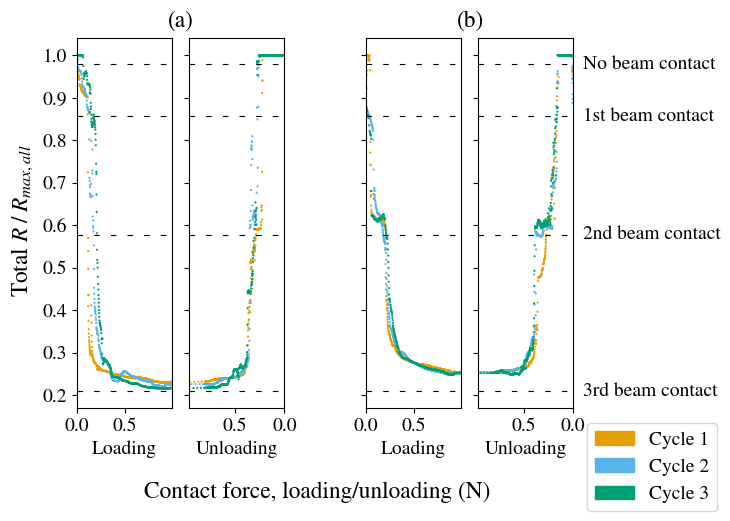

In [5]:
mpl.rcParams['font.size']        = 14
mpl.rcParams['font.family']      = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'

# palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Wong 2011 color blind accessible palette
palette = [
    '#E69F00',
    '#56B4E9',
    '#009E73',
    # '#F0E442',
    '#0072B2',
    '#D55E00',
    '#CC79A7',
]

fig, axes = plt.subplots(
    ncols=3 * len(data) - 1,
    sharey=True,
    width_ratios=([2, 2, 1] * len(data))[:-1],
)

rmax = max([dat.dfdq.dropna().Resistance.max() for dat in data])

for dat in data:
    dat.dfdq['ResNorm'] = dat.dfdq.Resistance / rmax

rexp = [
    (195.2 / rmax, 'No beam contact'),
    (170.6 / rmax, '1st beam contact'),
    (115.2 / rmax, '2nd beam contact'),
    (041.8 / rmax, '3rd beam contact'),
]
for r, label in rexp:
    for ax in axes:
        ax.axhline(r, color='black', lw=0.8, dashes=[5, 10])
    axes[-1].text(-0.1, r, label, verticalalignment='center')

for dat, i in zip(data, itertools.count()):
    for loading, df in dat.dfdq.dropna().groupby('Loading'):
        for cycle, dff in df.groupby('Cycle'):
            ax = axes[loading + i * 3]
            ax.scatter(dff.Force, dff.ResNorm, marker='.', c=palette[cycle], edgecolor='none', s=10)
            ax.set_xlim(xmin=np.floor(dff.Force.min()), xmax=dff.Force.max())

            ax.set_xlabel('Loading')
            if loading:
                ax.invert_xaxis()
                # ax.set_title(f'({chr(ord("a") + i)}) {dat.label}', x=0, y=1.01)
                ax.set_title(f'({chr(ord("a") + i)})', x=-0.085, y=1.01)
                ax.set_xlabel('Unloading')

# fig.suptitle('Demonstrator response, device 3#2\n3 beams, 7.5 to 10 mm length, varied encapsulation')
fig.supxlabel('Contact force, loading/unloading (N)', y=-0.0875)
fig.supylabel('Total $R\\;/\\;R_{max, all}$')
for ax in axes[2::3]:
    ax.set_visible(False)

fig.legend([plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(3)], [f'Cycle {i+1}' for i in range(3)], bbox_to_anchor=[1.14, -0.125], loc='lower right')

plt.savefig('plot.png', dpi=600, bbox_inches='tight')
plt.show()